Agnieszka Dutka
# Laboratory 6 - Title .........................................

Contents:  
[0. KMP and Suffix Tree implementations](#0)  
[1. Dictionary of basic factors](#1)   
[2. Searching pattern with DBF](#2)  
[3. DBF vs Suffix tree Construction time](#3)   
[4. Real DBF size compared to file size](#4)  
[5. DBF vs KMP search times comparison](#5)  
 


<a id='0'></a>
## --Suffix Tree--

__Structures__

In [ ]:
class TreeNode:
    """ Node of Suffix Tree of text @text, representing indexes [@first, @last) """
    def __init__(self, text, first=0, last=0, parent=None): # defaults for root
        self.first = first
        self.last = last
        self.text = text # whole text
        self.parent = parent
        self.children = {}
        self.slink = None
         
    @property
    def length(self):
        return self.last - self.first       
    
    @property
    def label(self):
        return self.text[self.first : self.last]
    
    def add(self, first: int, last: int):
        child = TreeNode(self.text, first, last, self)
        self.children[self.text[first]] = child # add new child to parent
        return child
    
    def split(self, offset):
        new_parent_last = self.first+offset
        new_parent = TreeNode(self.text, self.first, new_parent_last, self.parent)
        new_parent.children[self.text[new_parent_last]] = self
        self.parent.children[self.text[self.first]] = new_parent # change child
        self.first = new_parent_last
        self.parent = new_parent
        return new_parent
        
    def child(self, c):
        return self.children.get(c, None)
    
    def find(self, word: list):
        if word is None:
            return True
        child = self.child(word[0])
        if child is None:
            return False
        offset = 1
        while offset < min(len(word), child.length):
            if word[offset] != child.label[offset]:
                return False
            offset += 1
        if offset == len(word):
            return True
        return child.find(word[offset:])
    
    def __str__(self, indent=0): # recursive display
        return '%s%s\n%s' % (indent * '  ', self.label, ''.join(
                child.__str__(indent + 1)
                for key, child in sorted(self.children.items())
            )
        )


#### McCreight algorithm for Suffix Tree

In [ ]:
def slow_find(node, first: int, last: int) -> (TreeNode, TreeNode):
    """ inserts [first, last) into suffix tree starting with @node searching letter by letter.
    @node: represents the potential head in each loop. 
    @return: head and added leaf """
    text = node.text
    offset = 0  # where exactly in the current node we are (offset from node.first)
    while node.child(text[first])  is not None: # looking for child with same first char 
        node = node.child(text[first]) # enter the child
        while node.first + offset < node.last and first<len(text): # traverse nodes letters
            if text[first] == text[node.first + offset]:
                offset += 1
                first += 1
            else:  # we're in the middle of the node
                node = node.split(offset) #CHANGED
                leaf = node.add(first, last)
                return node, leaf
        offset = 0
    leaf = node.add(first, last)
    return node, leaf

def fast_find(node, first: int , last: int) -> (TreeNode, int):
    """ returns furthest node on path [first, lasts) and length it occupies in this node 
    e.g: given: abaabb path: (ab)(aab)b -> node(aab), length=3"""
    assert node is not None
    text = node.text
    length = last - first
    if length == 0:
        return node, length
    node = node.child(text[first])
    while length > node.length: # skip entire node
        first += node.length
        length -= node.length
        node = node.child(text[first])
    return node, length

def McCreight(text):
    text_len = len(text)
    root = TreeNode(text)
    old_head = root
    leaf = root.add(0, text_len)
    for curr_i in range(1, text_len):
        if old_head == root:    # new suffix to attach = old leaf [1:]
            old_head, leaf = slow_find(root, leaf.first + 1, leaf.last)
            continue
        parent = old_head.parent
        if parent == root:      # find "highest" slink (aX - X) where oldHead = aX
            head_slink, h_len = fast_find(parent, old_head.first + 1, old_head.last)
        else:                   # find some lower slink (B-B)
            head_slink, h_len = fast_find(parent.slink, old_head.first, old_head.last)
        if h_len < head_slink.length: # actual head_slink ends in the middle of current head_slink
            head_slink = head_slink.split(h_len) # CHANGED
            new_head = head_slink
            leaf = new_head.add(leaf.first, leaf.last) # copy leaf 
        else:                   # head_slink is a node and has other children already - traverse children
            new_head, leaf = slow_find(head_slink, leaf.first, leaf.last)
        old_head.slink = head_slink # = head_slink
        old_head = new_head

    return root

## --Knuth-Morris-Pratt algorithm--

In [2]:
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while(k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]
        if(pattern[k] == pattern[q]):
            k = k + 1
        pi.append(k)
    return pi

def kmp_string_matching(text, pattern, pi):
    res = 0
    q = 0
    for i in range(0, len(text)):
        while(q > 0 and pattern[q] != text[i]):
            q = pi[q-1]
        if(pattern[q] == text[i]):
            q = q + 1
        if(q == len(pattern)):
            res += 1
            q = pi[q-1]
    return res

<a id='1'></a>
## --DBF--


In [5]:
def sort_rename(sequence):
    last_entry = None
    index = 0
    position_to_index=[None]*len(sequence)
    first_entry={}
    for entry in sorted([(e,i)for i,e in enumerate(sequence)]):
        if(last_entry and last_entry[0] != entry[0]):
            index += 1
            first_entry[index]=entry[1]
        position_to_index[entry[1]]=index
        if last_entry is None:
            first_entry[0] = entry[1]
        last_entry = entry
    return (position_to_index, first_entry)

In [6]:
sort_rename([(1,2),(3,1),(2,2),(1,1),(2,3),(1,2)])


([1, 4, 2, 0, 3, 1], {0: 3, 1: 0, 2: 2, 3: 4, 4: 1})

## KMR algorithm

based on the fact that:
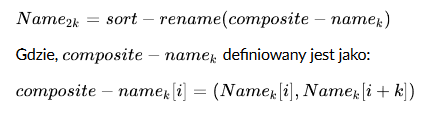

In [9]:
import math

def kmr(text):
    txt_len = len(text)
    factor = math.floor(math.log2(txt_len))
    max_len = 2**factor
    padding_len = 2**(factor+1)-1
    text += "z"*padding_len
    
    pos_to_idx, first_entry = sort_rename(list(text))
    names = {1: pos_to_idx}
    entries = {1: first_entry}
    for i in range(1, factor):
        power = 2**(i-1)
        new_seq = []
        for j in range(len(text)):
            if j+power < len(names[power]):
                new_seq.append((names[power][j], names[power][j+power]))
        pos_to_idx, first_entry = sort_rename(new_seq)
        names[power*2] = pos_to_idx
        entries[power*2] = first_entry
    return (names, entries)

In [11]:
text="abbabbaba"
names, entries=kmr(text)
print("names:")
for k,v in names.items():
    print(k,[e+1 for e in v[:len(text)]])
    
print("\npositions:")
for k,v in entries.items():
    print(k,[v[e]+1 for e in range(len(v)-1)])

names:
1 [1, 2, 2, 1, 2, 2, 1, 2, 1]
2 [1, 4, 3, 1, 4, 3, 1, 3, 2]
4 [2, 7, 5, 2, 7, 4, 1, 6, 3]

positions:
1 [1, 2]
2 [1, 9, 3, 2]
4 [7, 1, 9, 6, 3, 8, 2]
